In [ ]:
"""
Computational Magnetic Resonance Imaging (CMRI) 2024/2025 Winter semester

- Author          : Jinho Kim
- Email           : <jinho.kim@fau.de>
"""

from typing import Optional, Tuple

import numpy as np
import utils
from scipy.linalg import fractional_matrix_power, pinv


class Lab05_op:

    def load_data(self, dpath="data_brain_8coils.mat"):
        mat = utils.load_data(dpath)
        kdata = mat["d"]
        sens_maps = mat["c"]
        noise_maps = mat["n"]
        return kdata, sens_maps, noise_maps

    def sos_comb(self, m: np.ndarray, axis: int = -1) -> np.ndarray:
        """
        Sum of square.

        :param m: multicoil images [nPE, nFE, nCh]

        :return: mc: combined image [nPE, nFE]
        """
        # Your code here ... # do we need to normalize or something
        m_squared = np.square(np.abs(m))
        mc = np.sqrt(np.sum(m_squared,axis))
        return mc

    def ls_comb(
        self, coil_imgs: np.ndarray, sens_maps: np.ndarray, PSI: Optional[np.ndarray] = None, axis: int = -1, **kwargs
    ) -> np.ndarray:
        """
        Least-squares (matched filter)

        :param coil_imgs:               multicoil images [nPE,nFE,nCh]
        :param sens_maps:               coil sensitivity maps [nPE,nFE,nCh]
        :param PSI:                     (Optional) noise correlation matrix [nCh, nCh]

        :return: coil_comb_img:         combined image [nPE,nFE]
        """
        # PLEASE IGNORE HERE AND DO NOT MODIFY THIS PART.
        # Use 'apply_psi' in this method if you need to used it instead of calling it by self.apply_psi.
        apply_psi = kwargs.get("apply_psi", self.apply_psi)

        # Your code here ...
        m,n,p = np.shape(coil_imgs)
        temp = np.zeros((m,n),  dtype=complex)
        if PSI is None:
            for i in range(m):
                for k in range(n):
                    temp[i,k] = (np.conj(sens_maps[i,k,:]).T) @ coil_imgs[i,k,:]
                    if ((np.conj(sens_maps[i,k,:]).T) @ sens_maps[i,k,:]) != 0:
                        temp[i,k] /= ((np.conj(sens_maps[i,k,:]).T) @ sens_maps[i,k,:])

        if PSI is not None:
            # After 1.b.ii.2 and 1.b.ii.3, you should apply the noise correlation matrix to the coil sensitivity maps and coil images.
            sens_maps_t = op.apply_psi(sens_maps,PSI)
            coil_imgs_t = op.apply_psi(coil_imgs,PSI)
            for i in range(m):
                for k in range(n):
                    temp[i,k] = (np.conj(sens_maps_t[i,k,:]).T) @ coil_imgs_t[i,k,:]
                    if ((np.conj(sens_maps_t[i,k,:]).T) @ sens_maps_t[i,k,:]) != 0:
                        temp[i,k] /= ((np.conj(sens_maps_t[i,k,:]).T) @ sens_maps_t[i,k,:])


        coil_comb_img = temp
        return coil_comb_img

    def get_psi(self, noise_maps: np.ndarray) -> np.ndarray:
        """
        This function calculates the noise covariance matrix
        Use np.cov function to calculate the covariance matrix.

        Args:
            noise_maps (np.ndarray):    noise maps [nPE,nFE,nCh] ///////////// Is this correct ???

        Returns:
            psi (np.ndarray):           noise covariance matrix [nCh,nCh]
        """
        # Your code here ...
        n,p = np.shape(noise_maps)
        temp = np.zeros((p,p),dtype=complex)
        for i in range(p):
            for k in range(p):
                t = np.cov(noise_maps[:,i],noise_maps[:,k])
                temp[i,i] = t[0,0]
                temp[i,k] = t[0,1]
                temp[k,i] = t[1,0]
                temp[k,k] = t[1,1]
                            
        psi = temp
        return psi

    def apply_psi(self, x: np.ndarray, psi: np.ndarray) -> np.ndarray:
        """
        This function applies the coil noise covariance matrix to the image
        \Psi^{-1/2}x
        Use fractional_matrix_power function in the scipy.linalg package for fractional matrix power.
        Use @ operator for matrix multiplication.

        @parak
        x:          matrix of shape [nPE,nFE,nCh]
        psi:        matrix of shape [nCh,nCh]

        @return:
        y:          PSI applied matrix of shape [nPE,nFE,nCh]
        """
        # Raise an error if the dimensions are not correct
        assert (
            x.shape[-1] == psi.shape[0]
        ), "The last dimension of x must be equal to the first dimension of psi"

        # Your code here ...
        m,n,p = np.shape(x)
        temp = np.zeros([m,n,p],dtype=complex)
        half_psi = fractional_matrix_power(psi,-0.5)
        for i in range(m):
            for j in range(n):
                temp [i,j] = half_psi @ x[i,j]

        y = temp 
        return y

    def sense_locs(self, idx_PE: int, PE: int, R: int) -> np.ndarray:
        """
        Get the unwrapped indices for SENSE reconstruction.
        locs are equivalent to u_1, u_2,... in the lecture note.

        :param idx_PE:      index of PE
        :param PE:          number of PE
        :param R:           acceleration factor

        :return: locs:      indices for SENSE reconstruction [R]
        """
        # Your code here ...
        locs = []
        for i in range(R):
            t = idx_PE + i * np.ceil(PE/R) ################################### have to check again
            t = t % PE
            locs.append(int(t))
        return locs

    def sense_aliased_idx(self, PE: int, R: int, locs: np.ndarray) -> int:
        """
        Get an index for aliased image among indices in locs.
        i_n is an PE index of I_n in the lecture note.

        @param PE:          Length of phase encoding
        @param R:           Acceleration factor
        @param locs:        Indices for SENSE reconstruction at one point [R]

        @return: i_n:       An PE index for aliased images, I_n
        """
        # Your code here ...
        PE_reduced = np.ceil(PE/R)
        lower_bound = np.ceil(PE/2 - PE_reduced/2)
        upper_bound = lower_bound + PE_reduced -1 ######## np.ceil(PE/2 + PE_reduced/2)
        
        for loc in locs:
            if loc >= lower_bound and loc <= upper_bound:
                i_n = loc - lower_bound
        return int(i_n % PE_reduced)

    def sense_sm_pinv(self, sens_maps: np.ndarray, locs: np.ndarray, idx_RO: int) -> np.ndarray:
        """
        Get the pseudo-inverse of coil sensitivity maps
        Use pinv function in the scipy.linalg package for puedo inverse of the matrix.

        :param sens_maps:       coil sensitivity maps [nPE,nRO,nCh]
        :param locs:            indices for SENSE reconstruction [R]
        :param idx_RO:          index of RO

        :return: C_pinv:        pseudo-inverse of coil sensitivity maps [R,nCh]
        """
        # Your code here ...
        R = np.shape(locs)[0]
        num_coils = np.shape(sens_maps)[2]
        C = np.zeros([num_coils,R],dtype=complex)
        for i in range(num_coils):
            for j in range(R):
                C[i,j] = sens_maps[locs[j],idx_RO,i]
        C_pinv = pinv(C)
        return C_pinv

    def sense_unwrap(self, aliased_imgs: np.ndarray, sm_pinv: np.ndarray, idx_PE_alias: int, idx_RO: int) -> np.ndarray:
        """
        Unwrap the aliased coefficient to get the unaliased image
        Use @ operator for matrix multiplication.

        :param aliased_imgs:        aliased images [Ceil(nPE/R),nRO,nCh]
        :param sm_pinv:             pseudo-inverse of coil sensitivity maps [R,nCh]
        :param idx_PE_alias:        index of PE for aliased image
        :param idx_RO:              index of RO

        :return: unwrapped_coeff:   unwrapped coefficients [R]

        """
        # Your code here ...
        R, num_coils = np.shape(sm_pinv) 
        temp = np.zeros([num_coils],dtype=complex)
        for i in range (num_coils):
            temp[i] = aliased_imgs[idx_PE_alias,idx_RO,i]
        unwrapped_coeff = sm_pinv @ temp
        return unwrapped_coeff

    def sense_g_coef(self, sens_maps: np.ndarray, locs: np.ndarray, idx_RO: int) -> np.ndarray:
        """
        Get the g-factor. Use calc_g function in the utils package.

        :param sens_maps:       coil sensitivity maps [nPE,nRO,nCh]
        :param locs:            indices for SENSE reconstruction [R]
        :param idx_RO:          index of RO

        :return: g:             g-factor [R]
        """
        # Your code here ...
        R = np.shape(locs)[0]
        nPE,nRO,nCh = np.shape(sens_maps)
        temp = np.zeros([nCh,R],dtype=complex)
        for i in range(nCh):
            for j in range(R):
                temp[i,j] = sens_maps[locs[j],idx_RO,i]
        g = utils.calc_g(temp)
        return g

    def sense_recon(
        self, aliased_imgs: np.ndarray, sens_maps: np.ndarray, PSI: np.ndarray, R: int, **kwargs
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        SENSE reconstruction.

        :param aliased_imgs:        multicoil aliased images [Ceil(nPE/R),nRO,nCh]
        :param sens_maps:           coil sensitivity maps [nPE,nRO,nCh]
        :param PSI:                 noise correlation matrix [nCh, nCh]
        :param R:                   acceleration factor

        :return:
            unaliased_img:          unaliased image [nPE,nRO]
            g_map:                  g-factor map [nPE,nRO]
        """
        # PLEASE IGNORE HERE AND DO NOT MODIFY THIS PART.
        apply_psi = kwargs.get("apply_psi", self.apply_psi)
        sense_locs = kwargs.get("sense_locs", self.sense_locs)
        sense_sm_pinv = kwargs.get("sense_sm_pinv", self.sense_sm_pinv)
        sense_g_coef = kwargs.get("sense_g_coef", self.sense_g_coef)
        sense_aliased_idx = kwargs.get("sense_aliased_idx", self.sense_aliased_idx)
        sense_unwrap = kwargs.get("sense_unwrap", self.sense_unwrap)

        PE, RO, _ = sens_maps.shape
        sens_maps = apply_psi(sens_maps, PSI)
        aliased_imgs = apply_psi(aliased_imgs, PSI)

        nonzero_idx = np.array(np.nonzero(np.sum(sens_maps, 2)))
        unaliased_img = np.zeros((PE, RO), dtype=aliased_imgs.dtype)
        g_map = np.zeros((PE, RO))

        for idx_PE, idx_RO in zip(*nonzero_idx):
            if not unaliased_img[idx_PE, idx_RO]:
                # SENSE reconstruction
                # Your code here ...
                locs = sense_locs(idx_PE,PE,R)
                pinv = sense_sm_pinv(sens_maps,locs,idx_RO)
                aliased_idx = sense_aliased_idx(PE,R,locs)
                unwrap_coef = sense_unwrap(aliased_imgs,pinv,aliased_idx,idx_RO)
                for i in range(R):
                    unaliased_img[locs[i],idx_RO] = unwrap_coef[i]

                # g-factor
                # Your code here ...
                g = sense_g_coef(sens_maps,locs, idx_RO)
                for i in range(R):
                    g_map[locs[i],idx_RO] = g[i]

        return unaliased_img, g_map
    
op = Lab05_op()

In [55]:

kdata, sens_maps, noise_maps = op.load_data()
psi = op.get_psi(noise_maps)
aliased_img = utils.ifft2c(kdata[::2], axes=(0, 1))

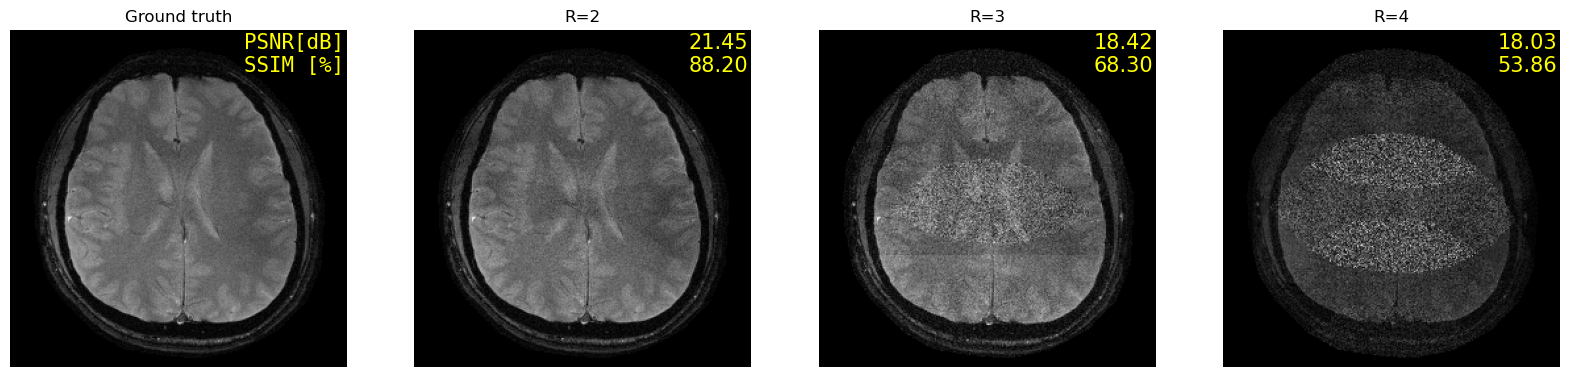

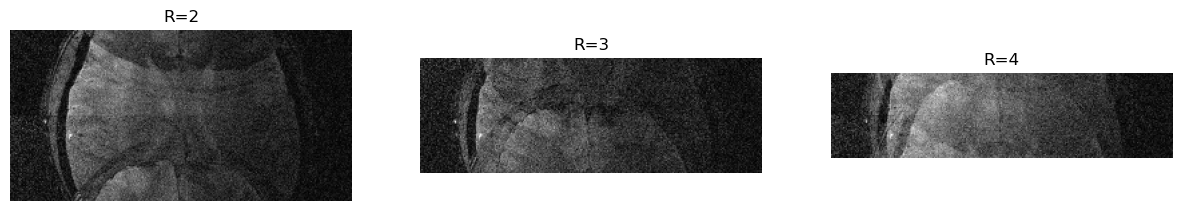

In [56]:
coil_imgs = utils.ifft2c(kdata, axes=(0, 1))
# complex sum
complex_sum = utils.cmplx_sum(coil_imgs)

# Sum of squares
sos = op.sos_comb(coil_imgs)

# Least-squares w/o pre-whitening
ls = op.ls_comb(coil_imgs, sens_maps)

# Least-squres w/ pre-whitening
PSI = op.get_psi(noise_maps)
ls_wPSI = op.ls_comb(coil_imgs, sens_maps, PSI)


senses = []
recon_us = []
title_R, title_g = [], []
gs = []
for R in [2, 3, 4]:
    aliased_img = utils.ifft2c(kdata[::R], axes=(0, 1))
    unaliased_img, g_maps = op.sense_recon(aliased_img, sens_maps, PSI, R)
    senses.append(unaliased_img)
    recon_us.append(aliased_img[..., 3])
    gs.append(g_maps)
    title_R.append(f"R={R}")
    title_g.append(f"g-factor={np.mean(g_maps[np.nonzero(g_maps)]): .2f}")
utils.imshow(senses, gt=ls_wPSI, titles=title_R)
utils.imshow(recon_us, titles=title_R)

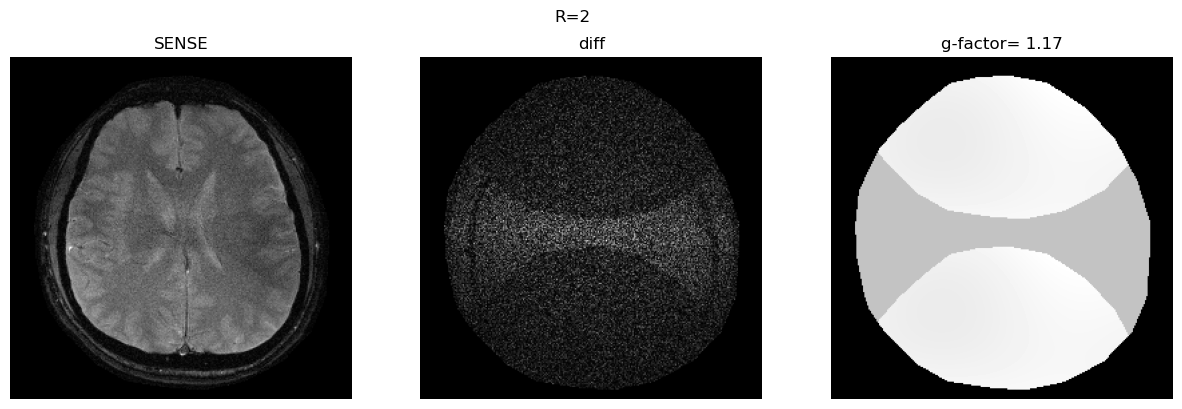

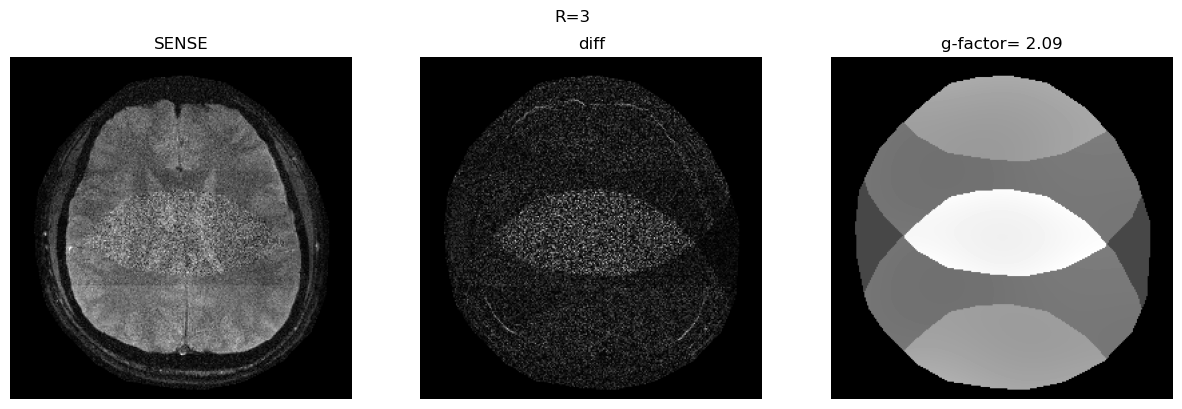

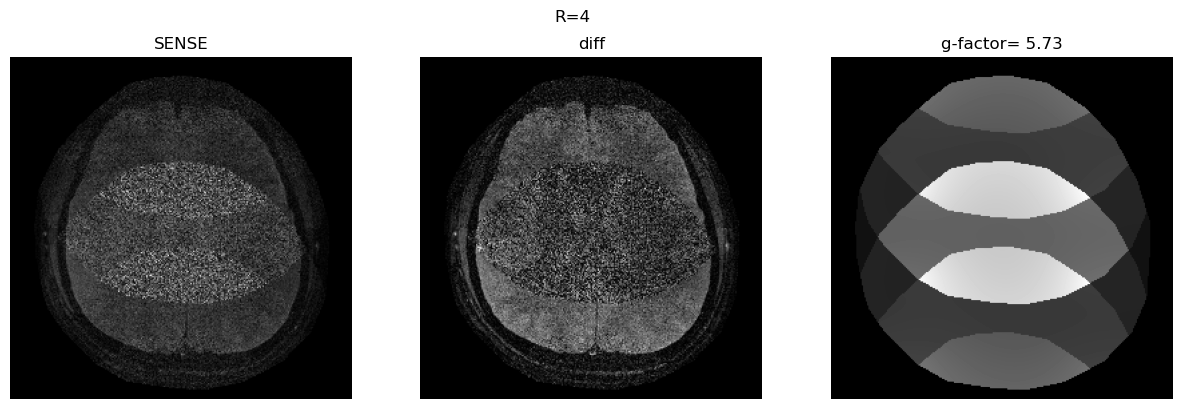

In [15]:
senses_norm = [utils.normalization(i) for i in senses]
ls_wPSI_norm = utils.normalization(ls_wPSI)
senses_diff = [ls_wPSI_norm - i for i in senses_norm]

for i in range(len(senses_norm)):
    utils.imshow(
        [senses_norm[i], senses_diff[i], gs[i]],
        titles=["SENSE", "diff", title_g[i]],
        suptitle=title_R[i],
    )

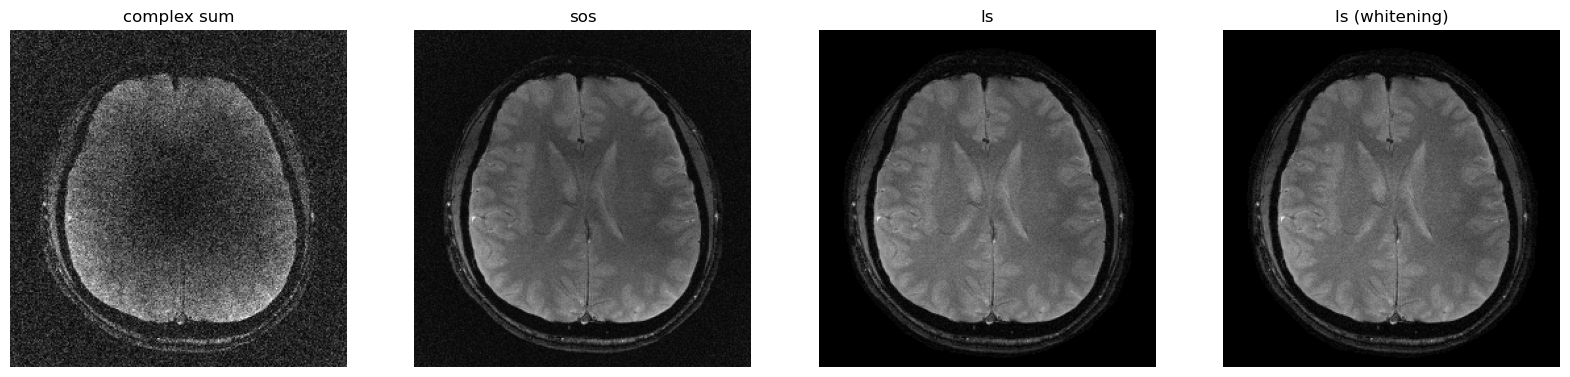

In [32]:
utils.imshow(
    [complex_sum, sos, ls, ls_wPSI],
    titles=["complex sum", "sos", "ls", "ls (whitening)"],
)

In [53]:
a = 300+98.33+93.43+93.33
print(a/6)

97.515
